In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, datediff, year, month, to_date, when, expr, current_date
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline

In [ ]:
spark = SparkSession.builder.appName("CRM_ERP_Analysis").getOrCreate()

fact_sales_df = spark.read.csv("s3a://warehouse/dataafterdremio/fact_sales.csv", header=True, inferSchema=True)
dim_dates_df = spark.read.csv("s3a://warehouse/dataafterdremio/dim_dates.csv", header=True, inferSchema=True)
dim_products_df = spark.read.csv("s3a://warehouse/dataafterdremio/dim_products.csv", header=True, inferSchema=True)
dim_customers_df = spark.read.csv("s3a://warehouse/dataafterdremio/dim_customers.csv", header=True, inferSchema=True)

fact_sales_df.createOrReplaceTempView("fact_sales")
dim_dates_df.createOrReplaceTempView("dim_dates")
dim_products_df.createOrReplaceTempView("dim_products")
dim_customers_df.createOrReplaceTempView("dim_customers")
dim_customers_df = dim_customers_df \
    .withColumn("birthday", to_date(col("birthday"))) \
    .withColumn("join_crm_date_parsed", to_date(col("join_crm_date"), "M/d/yyyy")) \
    .withColumn("age", year(current_date()) - year(col("birthday")))

dim_customers_df.createOrReplaceTempView("dim_customers")


# 1. Phân tích CRM


## 1.1 Phân nhóm khách hàng theo giới tính, tình trạng hôn nhân và quốc gia

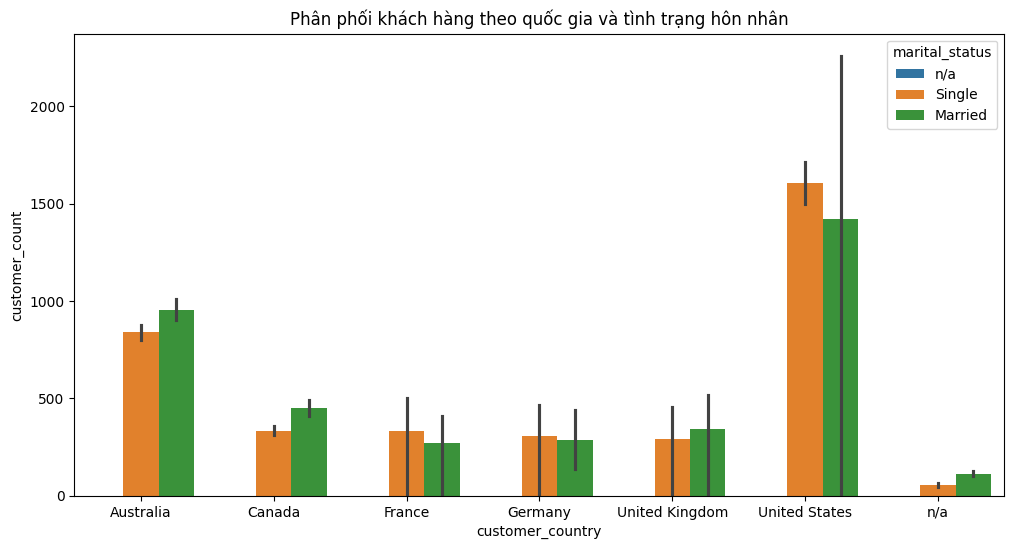

In [4]:
crm_gender_marital = spark.sql("""
SELECT customer_country, gender, marital_status, COUNT(*) AS customer_count
FROM dim_customers
GROUP BY customer_country, gender, marital_status
ORDER BY customer_country, gender
""").toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=crm_gender_marital, x="customer_country", y="customer_count", hue="marital_status")
plt.title("Phân phối khách hàng theo quốc gia và tình trạng hôn nhân")
plt.show()


## 1.2 Tỷ lệ khách hàng mới theo năm gia nhập CRM

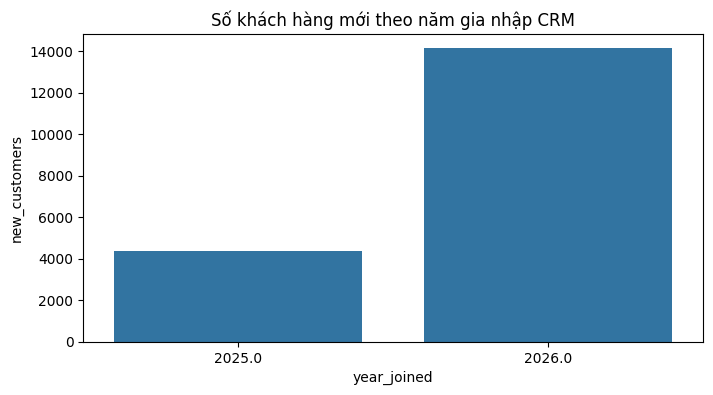

In [6]:
crm_new_customers = spark.sql("""
SELECT YEAR(join_crm_date_parsed) AS year_joined, COUNT(DISTINCT customer_key) AS new_customers
FROM dim_customers
GROUP BY YEAR(join_crm_date_parsed)
ORDER BY year_joined
""").toPandas()

plt.figure(figsize=(8, 4))
sns.barplot(data=crm_new_customers, x="year_joined", y="new_customers")
plt.title("Số khách hàng mới theo năm gia nhập CRM")
plt.show()



## 1.3 Phân nhóm khách hàng theo độ tuổi & giới tính, xem tổng chi tiêu:

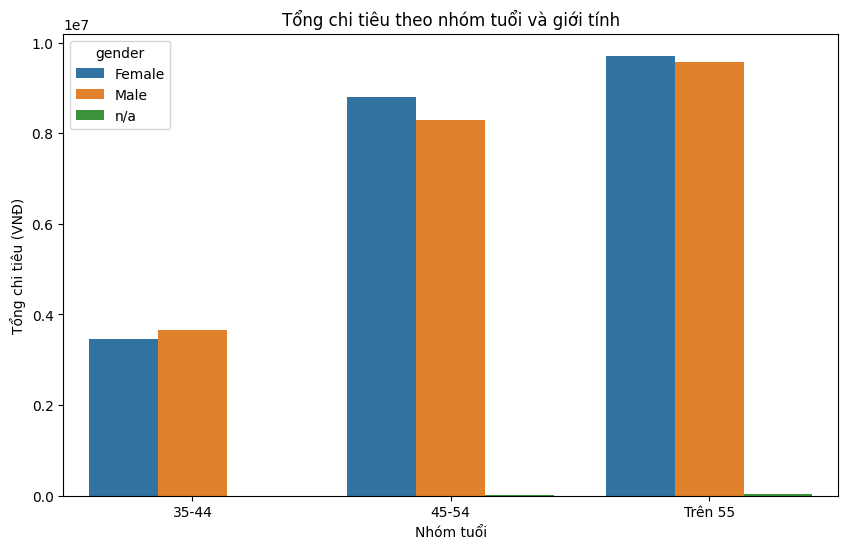

In [9]:
crm_spending = spark.sql("""
SELECT
  CASE
    WHEN age < 25 THEN 'Dưới 25'
    WHEN age BETWEEN 25 AND 34 THEN '25-34'
    WHEN age BETWEEN 35 AND 44 THEN '35-44'
    WHEN age BETWEEN 45 AND 54 THEN '45-54'
    ELSE 'Trên 55'
  END AS nhom_tuoi,
  gender,
  SUM(f.total_amount) AS tong_chi_tieu
FROM fact_sales f
JOIN (
  SELECT
    customer_key,
    gender,
    FLOOR(DATEDIFF(current_date(), birthday) / 365) AS age  -- tính tuổi
  FROM dim_customers
) c ON f.customer_key = c.customer_key
GROUP BY nhom_tuoi, gender
ORDER BY nhom_tuoi, gender

""")

pdf_crm_spending = crm_spending.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(data=pdf_crm_spending, x='nhom_tuoi', y='tong_chi_tieu', hue='gender')
plt.title("Tổng chi tiêu theo nhóm tuổi và giới tính")
plt.xlabel("Nhóm tuổi")
plt.ylabel("Tổng chi tiêu (VNĐ)")
plt.show()



# 2. Phân tích chuyên sâu ERP (Sales & Products)


## 2.1 Top 10 sản phẩm có doanh thu cao nhất và lợi nhuận (doanh thu - chi phí)

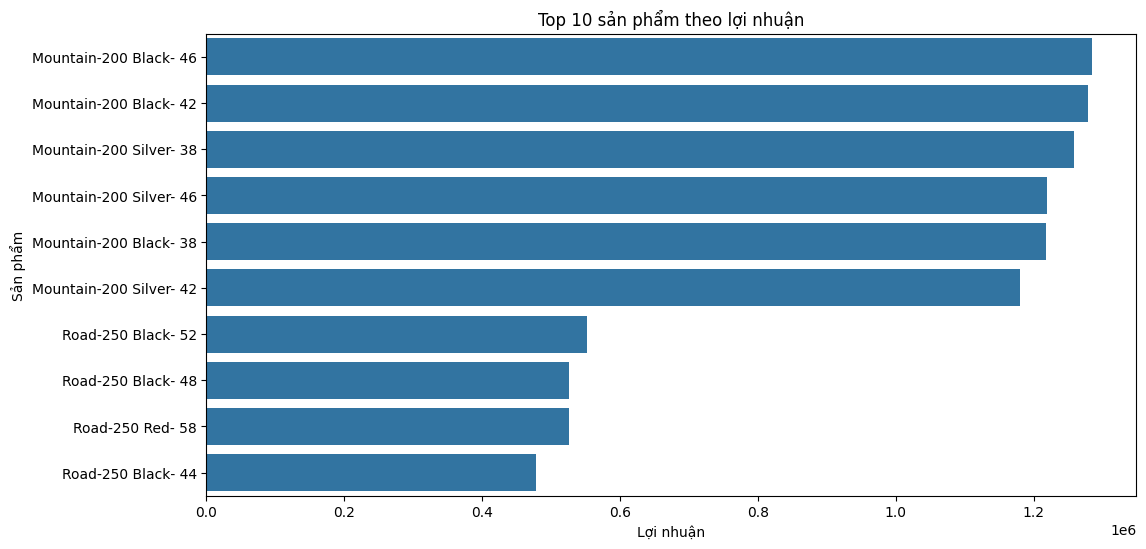

In [ ]:
erp_top_products = spark.sql("""
SELECT p.product_name,
       SUM(f.total_amount) AS revenue,
       SUM(f.quantity * p.product_cost) AS cost,
       SUM(f.total_amount) - SUM(f.quantity * p.product_cost) AS profit
FROM fact_sales f
JOIN dim_products p ON f.product_key = p.product_key
GROUP BY p.product_name
ORDER BY profit DESC
LIMIT 10
""").toPandas()

plt.figure(figsize=(12,6))
sns.barplot(data=erp_top_products, x="profit", y="product_name")
plt.title("Top 10 sản phẩm theo lợi nhuận")
plt.xlabel("Lợi nhuận")
plt.ylabel("Sản phẩm")
plt.show()


## 2.2 Phân tích doanh thu theo quý và dòng sản phẩm

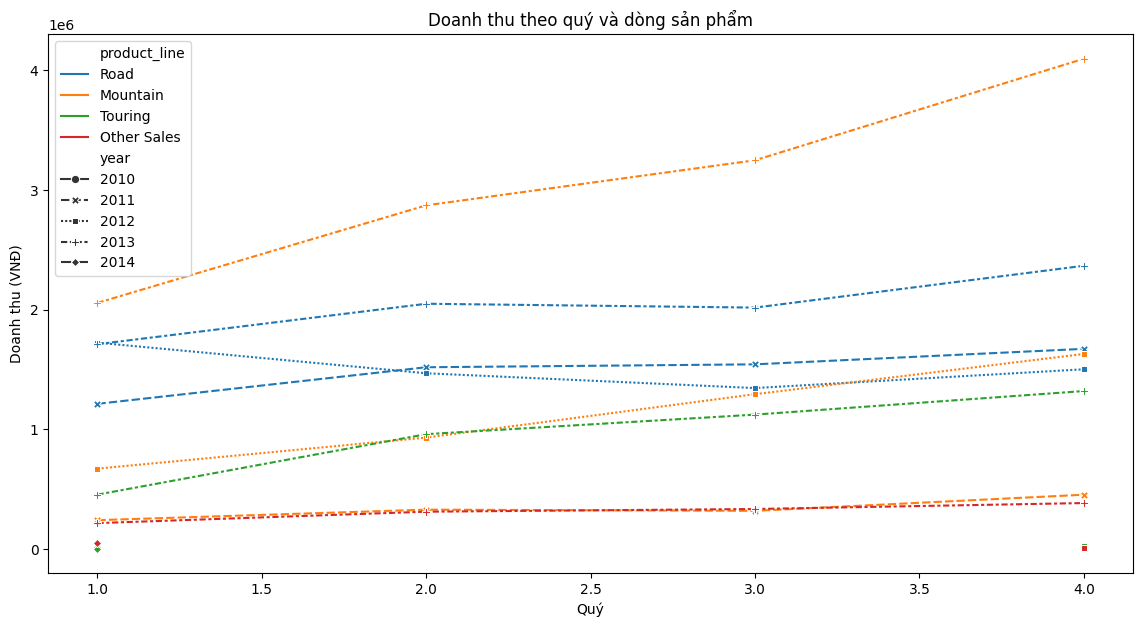

In [ ]:
quarter_revenue = spark.sql("""
SELECT
  d.year,
  d.quarter,
  p.product_line,
  SUM(f.total_amount) AS doanh_thu
FROM fact_sales f
JOIN dim_dates d ON DATE(f.order_date) = DATE(d.date_id)
JOIN dim_products p ON f.product_key = p.product_key
GROUP BY d.year, d.quarter, p.product_line
ORDER BY d.year, d.quarter, doanh_thu DESC
""")

pdf_quarter_revenue = quarter_revenue.toPandas()
plt.figure(figsize=(14,7))
import seaborn as sns

sns.lineplot(data=pdf_quarter_revenue, x='quarter', y='doanh_thu', hue='product_line', style='year', markers=True)
plt.title("Doanh thu theo quý và dòng sản phẩm")
plt.xlabel("Quý")
plt.ylabel("Doanh thu (VNĐ)")
plt.show()


# Mô hình học máy

## 1. Phân khúc khách hàng (Customer Segmentation) bằng K-Means Clustering

Data count before filtering: 18468, after filtering: 17157
Silhouette score for k=2: 0.6478
Silhouette score for k=3: 0.5736
Silhouette score for k=4: 0.4998
Silhouette score for k=5: 0.6209
Silhouette score for k=6: 0.5900
Silhouette score for k=7: 0.5451
Silhouette score for k=8: 0.5477
Silhouette score for k=9: 0.5872
Silhouette score for k=10: 0.5897


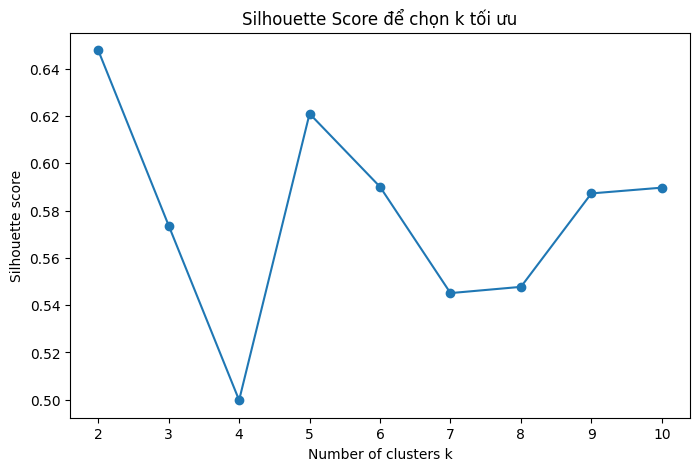

Chọn k = 2 với Silhouette score = 0.6478


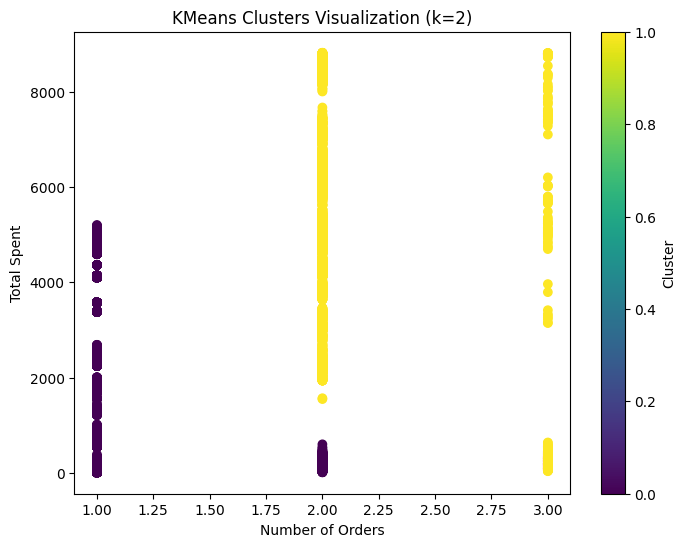

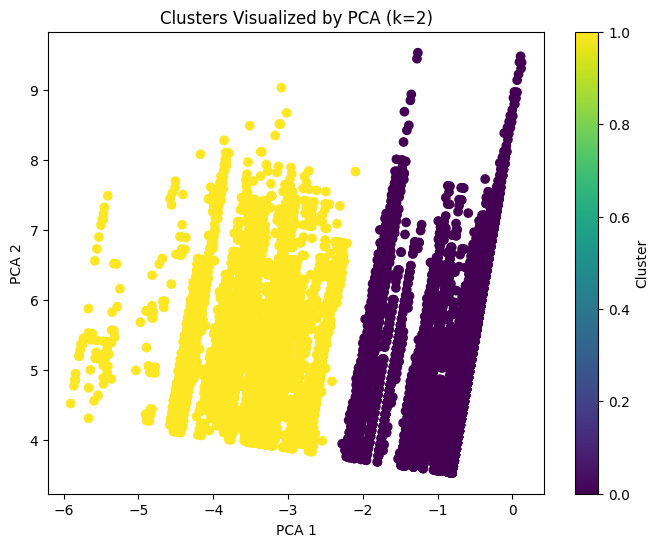

In [ ]:
customer_sales = spark.sql("""
    SELECT f.customer_key,
           COUNT(DISTINCT f.order_id) AS num_orders,
           SUM(f.total_amount) AS total_spent
    FROM fact_sales f
    GROUP BY f.customer_key
""")

customer_info = spark.sql("SELECT customer_key, birthday FROM dim_customers") \
    .withColumn("age", year(current_date()) - year(col("birthday")))

data = customer_sales.join(customer_info, "customer_key").na.drop()

def remove_outliers_iqr(df, col_name):
    Q1, Q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df.filter((col(col_name) >= lower) & (col(col_name) <= upper))

data_filtered = remove_outliers_iqr(data, "num_orders")
data_filtered = remove_outliers_iqr(data_filtered, "total_spent")

print(f"Data count before filtering: {data.count()}, after filtering: {data_filtered.count()}")

assembler = VectorAssembler(inputCols=["num_orders", "total_spent", "age"], outputCol="features_unscaled")
data_filtered = assembler.transform(data_filtered)

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")
scaler_model = scaler.fit(data_filtered)
data_filtered = scaler_model.transform(data_filtered)

evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette_scores = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(data_filtered)
    preds = model.transform(data_filtered)
    score = evaluator.evaluate(preds)
    silhouette_scores.append(score)
    print(f"Silhouette score for k={k}: {score:.4f}")
  
plt.figure(figsize=(8,5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score để chọn k tối ưu")
plt.show()

best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Chọn k = {best_k} với Silhouette score = {max(silhouette_scores):.4f}")

kmeans = KMeans(featuresCol="features", k=best_k, seed=1)
model = kmeans.fit(data_filtered)
predictions = model.transform(data_filtered)

plot_data = predictions.select("num_orders", "total_spent", "prediction").toPandas()

plt.figure(figsize=(8,6))
scatter = plt.scatter(plot_data["num_orders"], plot_data["total_spent"], c=plot_data["prediction"], cmap='viridis')
plt.xlabel("Number of Orders")
plt.ylabel("Total Spent")
plt.title(f"KMeans Clusters Visualization (k={best_k})")
plt.colorbar(scatter, label='Cluster')
plt.show()

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(predictions)
pca_result = pca_model.transform(predictions)

pdf = pca_result.select("pca_features", "prediction").toPandas()
pdf['pca1'] = pdf['pca_features'].apply(lambda x: x[0])
pdf['pca2'] = pdf['pca_features'].apply(lambda x: x[1])

plt.figure(figsize=(8,6))
scatter = plt.scatter(pdf["pca1"], pdf["pca2"], c=pdf["prediction"], cmap='viridis')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"Clusters Visualized by PCA (k={best_k})")
plt.colorbar(scatter, label='Cluster')
plt.show()


## 2. Dự đoán khách hàng rời bỏ (Churn Prediction)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, datediff, year, current_date, when, rand, exp
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName("Churn_Prediction_Complex").getOrCreate()

latest_date = spark.sql("SELECT MAX(order_date) FROM fact_sales").collect()[0][0]

customer_last_purchase = spark.sql("""
    SELECT customer_key, MAX(order_date) AS last_order_date
    FROM fact_sales
    GROUP BY customer_key
""")

customer_recency = customer_last_purchase.withColumn(
    "recency", datediff(lit(latest_date), col("last_order_date"))
)

customer_frequency_qty = spark.sql("""
    SELECT customer_key,
           COUNT(DISTINCT order_id) AS frequency,
           SUM(quantity) AS total_quantity,
           SUM(total_amount) AS total_spent
    FROM fact_sales
    GROUP BY customer_key
""")

customer_info_enhanced = spark.sql("""
    SELECT customer_key, birthday, gender, marital_status
    FROM dim_customers
""").withColumn(
    "age", year(current_date()) - year(col("birthday"))
).drop("birthday")

data = customer_recency.join(customer_frequency_qty, "customer_key") \
                       .join(customer_info_enhanced, "customer_key").na.drop()

data = data.withColumn(
    "churn_score",
    1 / (1 + exp(
        -(
            0.02 * col("recency") -
            0.5 * col("frequency") -
            0.0005 * col("total_spent") +
            0.01 * col("age")
        )
    ))
)

data = data.withColumn(
    "churn_score_noisy",
    col("churn_score") + (rand() - 0.5) * 0.1
)

threshold = 0.6
data = data.withColumn(
    "churn",
    when(col("churn_score_noisy") > threshold, 1).otherwise(0)
)

data.groupBy("churn").count().show()

indexer_gender = StringIndexer(inputCol="gender", outputCol="gender_index", handleInvalid="keep")
indexer_marital = StringIndexer(inputCol="marital_status", outputCol="marital_index", handleInvalid="keep")

assembler_num = VectorAssembler(
    inputCols=["recency", "frequency", "total_quantity", "total_spent", "age"], outputCol="num_features"
)
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_num_features")

assembler_final = VectorAssembler(
    inputCols=["scaled_num_features", "gender_index", "marital_index"], outputCol="features"
)

lr = LogisticRegression(labelCol="churn", probabilityCol="probability", threshold=0.5)

pipeline = Pipeline(stages=[
    indexer_gender,
    indexer_marital,
    assembler_num,
    scaler,
    assembler_final,
    lr
])

train, test = data.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train)
predictions = model.transform(test)
predictions.select("customer_key", "churn", "prediction", "probability").show(10)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")

accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

print("=== Test Metrics ===")
print(f"Accuracy = {accuracy:.4f}")
print(f"Precision = {precision:.4f}")
print(f"Recall = {recall:.4f}")
print(f"F1-score = {f1:.4f}")

train_predictions = model.transform(train)

train_accuracy = evaluator_accuracy.evaluate(train_predictions)
train_precision = evaluator_precision.evaluate(train_predictions)
train_recall = evaluator_recall.evaluate(train_predictions)
train_f1 = evaluator_f1.evaluate(train_predictions)

print("=== Train Metrics ===")
print(f"Accuracy = {train_accuracy:.4f}")
print(f"Precision = {train_precision:.4f}")
print(f"Recall = {train_recall:.4f}")
print(f"F1-score = {train_f1:.4f}")


+-----+-----+
|churn|count|
+-----+-----+
|    1|13592|
|    0| 4874|
+-----+-----+

+------------+-----+----------+--------------------+
|customer_key|churn|prediction|         probability|
+------------+-----+----------+--------------------+
|           3|    1|       1.0|[0.10947408530904...|
|           7|    0|       0.0|[0.99999999966782...|
|           9|    0|       0.0|[0.63747744103676...|
|          14|    0|       0.0|[0.99999925116048...|
|          20|    0|       0.0|           [1.0,0.0]|
|          24|    0|       0.0|[0.99999174588585...|
|          30|    0|       0.0|           [1.0,0.0]|
|          36|    0|       0.0|           [1.0,0.0]|
|          46|    1|       1.0|[9.55938797699331...|
|          47|    0|       0.0|           [1.0,0.0]|
+------------+-----+----------+--------------------+
only showing top 10 rows

=== Test Metrics ===
Accuracy = 0.9835
Precision = 0.9836
Recall = 0.9835
F1-score = 0.9835
=== Train Metrics ===
Accuracy = 0.9854
Precision = 0.9

## 3. Product Recommendation bằng ALS (Collaborative Filtering)

In [ ]:
ratings = spark.sql("""
    SELECT customer_key, product_key, SUM(quantity) AS rating
    FROM fact_sales
    GROUP BY customer_key, product_key
""")

train, test = ratings.randomSplit([0.8, 0.2], seed=42)

als = ALS(
    userCol="customer_key",
    itemCol="product_key",
    ratingCol="rating",
    coldStartStrategy="drop",  
    nonnegative=True,
    maxIter=10,
    regParam=0.1,
    rank=10,
    seed=42
)

model = als.fit(train)
predictions = model.transform(test)
predictions.show(10)

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error (RMSE) trên tập test = {rmse:.4f}")

user_id = 1
user_recs = model.recommendForUserSubset(ratings.filter(col("customer_key") == user_id), 5)
user_recs.show(truncate=False)


+------------+-----------+------+----------+
|customer_key|product_key|rating|prediction|
+------------+-----------+------+----------+
|         463|         39|     1| 0.8530283|
|         471|         29|     2| 1.7990896|
|         833|        309|     1|0.91225445|
|         833|        311|     1| 0.9138823|
|        1088|        386|     1| 0.8703715|
|        1238|         30|     1|0.91444105|
|        1238|         33|     1|0.91168624|
|        1238|        131|     1| 0.9026317|
|        1342|        127|     1|  1.192282|
|        1342|        286|     1| 1.2046264|
+------------+-----------+------+----------+
only showing top 10 rows

Root-mean-square error (RMSE) trên tập test = 0.2096
+------------+--------------------------------------------------------------------------------------------+
|customer_key|recommendations                                                                             |
+------------+-------------------------------------------------------------